In [485]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy import linalg as sLA
import time
from scipy.interpolate import interp1d
from IPython.display import Image
from IPython.display import display, Latex

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
# style.use('ggplot')

import sys
sys.path.append("../scripts")


from Gates import *
from functions import *
from State import *

d = 2

In [442]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Построим схему на квантовом компьютере IBM и считаем калибровочные параметры:

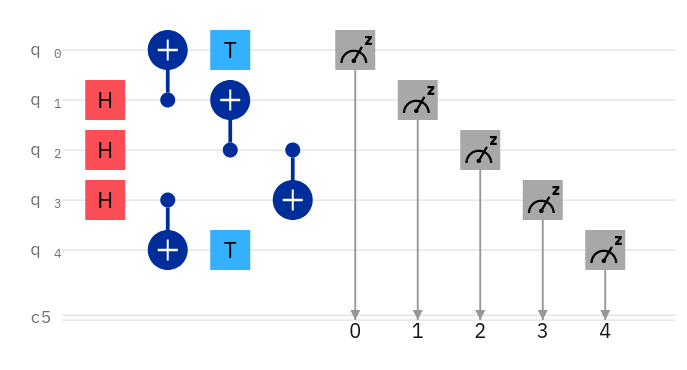

In [440]:
Image('circ.png')

Будем успользовать ibmq_manila, тк подходит по связности кубитов

In [461]:
df = pd.read_csv('ibmq_manila_calibrations.csv')
# df = pd.read_csv('ibmq_belem_calibrations.csv')

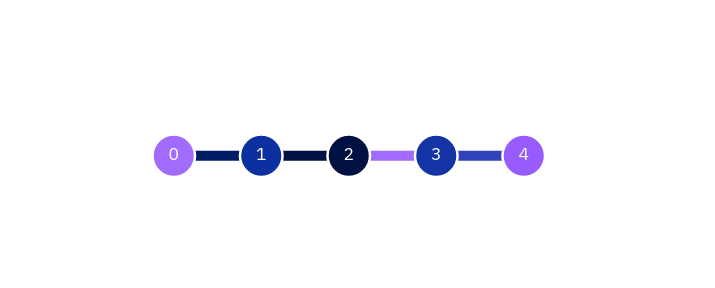

In [462]:
Image('conn.png')

связность кубитов

In [463]:
df

,Qubit,T1 (us),T2 (us),Frequency (GHz),Anharmonicity (GHz),Readout assignment error,Prob meas0 prep1,Prob meas1 prep0,Readout length (ns),ID error,√x (sx) error,Single-qubit Pauli-X error,CNOT error,Gate time (ns)
0,Q0,194.97,107.35,4.963,-0.34335,0.0196,0.0286,0.0106,5351.111,0.000167,0.000167,0.000167,0_1:7.148e-3,0_1:277.333
1,Q1,181.75,64.18,4.838,-0.34621,0.0335,0.0350,0.0320,5351.111,0.000225,0.000225,0.000225,1_0:7.148e-3; 1_2:1.618e-2,1_0:312.889; 1_2:469.333
2,Q2,141.08,22.98,5.037,-0.34366,0.1225,0.1110,0.1340,5351.111,0.000445,0.000445,0.000445,2_1:1.618e-2; 2_3:9.083e-3,2_1:504.889; 2_3:355.556
3,Q3,213.81,60.86,4.951,-0.34355,0.0188,0.0288,0.0088,5351.111,0.000222,0.000222,0.000222,3_4:6.628e-3; 3_2:9.083e-3,3_4:334.222; 3_2:391.111
4,Q4,83.40,33.42,5.066,-0.34211,0.0296,0.0450,0.0142,5351.111,0.000433,0.000433,0.000433,4_3:6.628e-3,4_3:298.667


In [464]:
df.columns

Index(['Qubit', 'T1 (us)', 'T2 (us)', 'Frequency (GHz)', 'Anharmonicity (GHz)',
       'Readout assignment error ', 'Prob meas0 prep1 ', 'Prob meas1 prep0 ',
       'Readout length (ns)', 'ID error ', '√x (sx) error ',
       'Single-qubit Pauli-X error ', 'CNOT error ', 'Gate time (ns)'],
      dtype='object')

In [465]:
# Достанем ошибки 

q1_err = df['Single-qubit Pauli-X error '].values # однокубитные ошибки
q2_err = df['CNOT error '].values # двухкубитные ошибки
p0_1 = df['Prob meas0 prep1 '].values # Ошибки
p1_0 = df['Prob meas1 prep0 '].values # измерения

q1_err, q2_err, p0_1, p1_0

(array([0.0001666, 0.0002249, 0.0004453, 0.0002217, 0.0004328]),
 array(['0_1:7.148e-3', '1_0:7.148e-3; 1_2:1.618e-2',
        '2_1:1.618e-2; 2_3:9.083e-3', '3_4:6.628e-3; 3_2:9.083e-3',
        '4_3:6.628e-3'], dtype=object),
 array([0.0286, 0.035 , 0.111 , 0.0288, 0.045 ]),
 array([0.0106, 0.032 , 0.134 , 0.0088, 0.0142]))

In [466]:
# Распарсим двухкубитные ошибки:

q2_err_dict = {}
for q2_full in q2_err:
    for q2 in q2_full.split('; '):
        inds, val = q2.split(':')
        val = float(val)
        ind = tuple([int(x) for x in inds.split('_')]) 
        q2_err_dict.update({ind:val})

q2_err_dict    

{(0, 1): 0.007148,
 (1, 0): 0.007148,
 (1, 2): 0.01618,
 (2, 1): 0.01618,
 (2, 3): 0.009083,
 (3, 4): 0.006628,
 (3, 2): 0.009083,
 (4, 3): 0.006628}

In [467]:
# переведём ошибки в коэффициенты для операторов Краусса:

q2_p = dict((key, val*16/15) for key, val in q2_err_dict.items())
q1_p = q1_err*4/3
r_p = r_err

q2_p, q1_p, r_p 

({(0, 1): 0.007624533333333333,
  (1, 0): 0.007624533333333333,
  (1, 2): 0.017258666666666665,
  (2, 1): 0.017258666666666665,
  (2, 3): 0.009688533333333334,
  (3, 4): 0.0070698666666666665,
  (3, 2): 0.009688533333333334,
  (4, 3): 0.0070698666666666665},
 array([0.00022213, 0.00029987, 0.00059373, 0.0002956 , 0.00057707]),
 array([0.0196, 0.0335, 0.1225, 0.0188, 0.0296]))

In [468]:
CX(wires = [0,1], N = 2), CX(wires = [1,0], N = 2)

(array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]]))

In [499]:
# Возвращает квантовую схему в виде листа последовательных 1-,2- кубитных преобразований,
# а так же список кубитов, на которые действуют выведенные преобразования

def Ansatz(n=5):   
    axis = [ 1, 3, [1,0], [3,4], 2, [2,1], [2,3], 0, 4]
    U = [H(1,n), H(3,n), CXa([1,0],n), CX([3,4],n), H(2,n), CXa([2,1],n), CX([2,3],n), T(0,n), T(4,n)]
    return U, axis

# Возвращает лист операторов Краусса, соответствующих однокубитным ошибкам 
# (внутри происходит расширение размерности до размерности всей системы)
def Kraus_list1q(nq = 0, n = 5, p_list = [0,0,0,0,0]):
    klist = [np.sqrt(1 - 3 * p_list[nq]/4) * I(nq,n),
             np.sqrt(p_list[nq]) * X(nq,n)/2, 
             np.sqrt(p_list[nq]) * Y(nq,n)/2,
             np.sqrt(p_list[nq]) * Z(nq,n)/2]
    return klist

err_dict = {(0, 1): 0,
            (1, 0): 0,
            (1, 2): 0,
            (2, 1): 0,
            (2, 3): 0,
            (3, 4): 0,
            (3, 2): 0,
            (4, 3): 0}

# Возвращает лист операторов Краусса, соответствующих двухкубитным ошибкам 
# (внутри происходит расширение размерности до размерности всей системы)
def Kraus_list2q(nq = (0,1), n = 5, p_dict = err_dict):
    tic_i = 0
    tic_j = 0
    klist = []
    p = 0
    for pauli0 in [I(nq[0],n), X(nq[0],n), Y(nq[0],n), Z(nq[0],n)]:
        for pauli1 in [I(nq[1],n), X(nq[1],n), Y(nq[1],n), Z(nq[1],n)]:
            if ((tic_i == 0) & (tic_j == 0)):
#                 print(nq, p_dict)
                p = np.sqrt(1 - 15 * p_dict[tuple(nq)] / 16)
            else:
                p = np.sqrt(1 * p_dict[tuple(nq)] / 16)
                
            klist.append(p*np.dot(pauli0, pauli1))
            tic_j += 1
        tic_i += 1
        
    return klist



# Возвращает Fidelity
def F(rho1, rho2):
    return np.abs(np.trace(sLA.sqrtm(sLA.sqrtm(rho1) @ rho2 @ sLA.sqrtm(rho1))))**2

# Осуществляет заданное преобразование над состоянием с матрицей плотности rho
# При noise = False в симуляции учитываются вероятности ошибок для конкретного квантового устройства,
# симуляция которого проводится
def Transform(rho0, Ansatz,n, p1, p2, noise = False):
    
    rho = copy.copy(rho0)
    U_list, axis = Ansatz()
#     print(U_list)
    
    for U, ax in zip(U_list, axis):
        rho = np.dot(np.dot(U,rho), U.conj().T)
        if noise == True:
            
            if type(ax) == list:
                rho_2 = np.zeros((2 ** n, 2 ** n), dtype=complex)
                for U in Kraus_list2q(nq = ax, n = n, p_dict = p2):
                    rho_2 += np.dot(np.dot(U,rho), U.conj().T)
                rho = rho_2


            else:
                rho_2 = np.zeros((2 ** n, 2 ** n), dtype=complex)
                for U in Kraus_list1q(nq = ax, n = n, p_list = p1):
                    rho_2 += np.dot(np.dot(U,rho), U.conj().T)
                rho = rho_2
            
    return rho

# Операторы измерения

p_0 = np.array([[1, 0],
                [0, 0]], dtype=complex)
p_1 = np.array([[0, 0],
                [0, 1]], dtype=complex)

def m0(e_10, e_01):
    return (1 - e_10) * p_0 + e_01 * p_1

def m1(e_10, e_01):
    return e_10 * p_0 + (1 - e_01) * p_1

m_list = [m0, m1]

# Возвращает результат измерения над матрицей плотности, учитывая заданные ошибки измерения
def Measurment(rho, p1_0, p0_1):
    d = len(rho)
    probs_sim = []
    for i in range(d):
        m=1
        bvec = bin(i)[2:].zfill(n)
        for j in range(5):
            j = 4 - j
            m = np.dot(m, expand(m_list[int(bvec[j])](p1_0[j], p0_1[j]), j, n))
        probs_sim.append(np.trace(m @ rho_new).real)
    return probs_sim

# функция для построения 3d гистограммы матрицы ( для матриц плотности)
def plot_matrix(m):
    
    style.use('ggplot')

    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111, projection='3d')
    
    xi = np.reshape(list(np.arange(m.shape[0]))*m.shape[1], (-1))
    yi = np.reshape(np.reshape((list(np.arange(m.shape[1]))*m.shape[0]), (m.shape[1], m.shape[0])).T, (-1))
    print(xi, yi)
    z0 = np.zeros(m.shape[0]*m.shape[1])
    
    dx = np.ones(m.shape[0]*m.shape[1])
    dy = np.ones(m.shape[1]*m.shape[0])
    dz = np.reshape(m, (-1))
    
    ax1.bar3d(xi, yi, z0, dx, dy, dz, shade=True)


    ax1.set_xlabel('x axis')
    ax1.set_ylabel('y axis')
    ax1.set_zlabel('z axis')

    plt.show()

In [500]:
# Зададим нулевое состояние
np.random.seed(2)

n = 5
state = Qpsi(n)
state.build_zero_state()

rho = state.get_rho()
rho

array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [501]:
# Проведём симуляцию без учёта ошибок и с их учётом
rho_new = Transform(rho, Ansatz, n, p1 = q1_p, p2 = q2_p, noise = False)
rho_new_noise = Transform(rho, Ansatz, n, p1 = q1_p, p2 = q2_p, noise = True)
r = F(rho_new, rho_new_noise)
display(Latex(r' $F(\rho^{end}, \rho^{end}_{noisy})$ = '))
F(rho_new, rho_new_noise)

<IPython.core.display.Latex object>

0.9630386139435078

In [503]:
sim_probs = Measurment(rho_new_noise, p1_0, p0_1)

In [504]:
# Достаним результаты вычислений на устройстве manila_ibm_q и квантовом симуляторе IBM

res_ibm = pd.read_csv('manila_chart_res.csv')
res_sim = pd.read_csv('test_hist.csv')

res_ibm.head(5)

,Measurement outcome,Frequency
0,0,550
1,1,121
2,10,138
3,11,445
4,100,470


In [505]:
# Нормируем статистику измерений состояний
res_state_sim = res_sim['Probability'].values
res_state_ibm = res_ibm['Frequency'].values
res_state_sim = res_state_sim/np.sum(res_state_sim)
res_state_ibm = res_state_ibm/np.sum(res_state_ibm)

#создадим матрицу, соответствующую модулю матрицы плотности, соответствующей симуляции
res_rho = np.outer(res_state_sim/np.sqrt(np.sum(res_state_sim**2)), res_state_sim/np.sqrt(np.sum(res_state_sim**2)))
np.sum(res_state_ibm), res_state_sim, res_rho

(1.0,
 array([0.125, 0.   , 0.   , 0.125, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.125, 0.125, 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.125, 0.125, 0.   , 0.125, 0.   , 0.   ,
        0.125, 0.   , 0.   , 0.   , 0.   ]),
 array([[0.125, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]))

In [534]:
res = pd.DataFrame()
res['state'] = [bin(x)[2:].zfill(n) for x in range(32)]
res['IBM'] = res_state_ibm
res['IBMsim'] = res_state_sim
res['Simulation'] = sim_probs

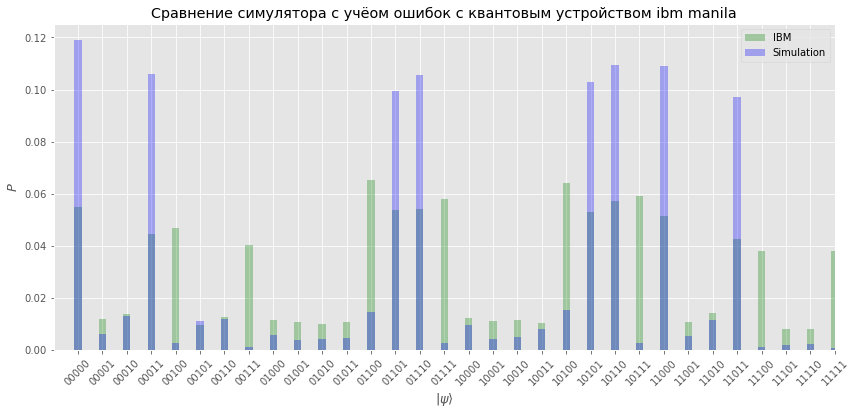

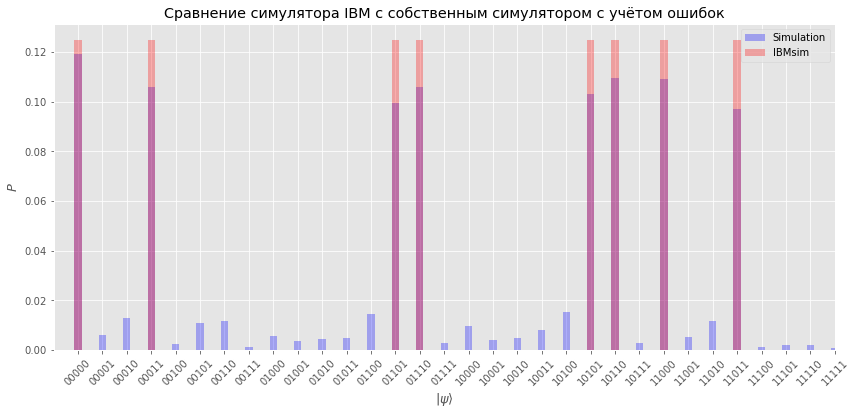

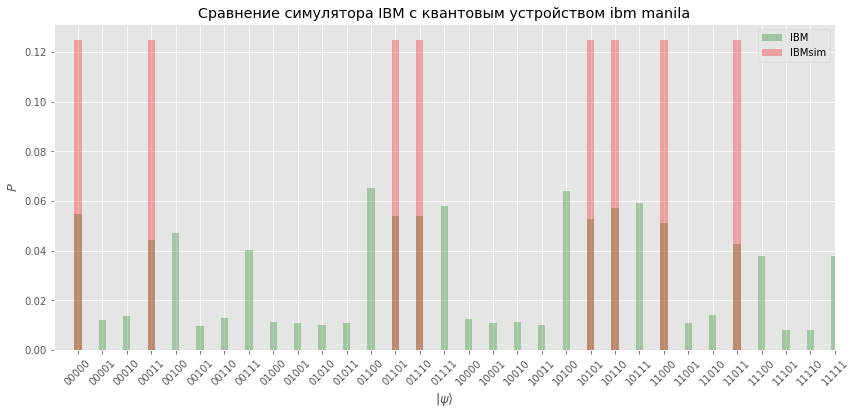

In [535]:
plt.figure(figsize = (14,6))
data_x = np.linspace(0, 31, 32)
data_x = [int(x) for x in data_x]
data_x = [bin(x)[2:].zfill(n) for x in data_x]
plt.title('Сравнение симулятора с учёом ошибок с квантовым устройством ibm manila')
plt.bar(data_x, res_state_ibm, width=0.3, color='green', alpha=0.3, label='IBM')
# plt.bar(data_x, res_state_sim, width=0.3, color='red', alpha=0.3, label='IBMsim')
plt.bar(data_x, data_probability_simulation, width=0.3, color='blue', alpha=0.3, label='Simulation')

plt.xticks(fontsize = 10, rotation = 45)
plt.yticks(fontsize = 10)


plt.xlabel(r'$|\psi\rangle$', fontsize=13)
plt.ylabel(r'$P$', fontsize=13)

plt.xlim(-1, 31)
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize = (14,6))
data_x = np.linspace(0, 31, 32)
data_x = [int(x) for x in data_x]
data_x = [bin(x)[2:].zfill(n) for x in data_x]
plt.title('Сравнение симулятора IBM с собственным симулятором с учётом ошибок')
# plt.bar(data_x, res_state_ibm, width=0.3, color='green', alpha=0.3, label='IBM')
plt.bar(data_x, data_probability_simulation, width=0.3, color='blue', alpha=0.3, label='Simulation')
plt.bar(data_x, res_state_sim, width=0.3, color='red', alpha=0.3, label='IBMsim')

plt.xticks(fontsize = 10, rotation = 45)
plt.yticks(fontsize = 10)


plt.xlabel(r'$|\psi\rangle$', fontsize=13)
plt.ylabel(r'$P$', fontsize=13)

plt.xlim(-1, 31)
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize = (14,6))
data_x = np.linspace(0, 31, 32)
data_x = [int(x) for x in data_x]
data_x = [bin(x)[2:].zfill(n) for x in data_x]
plt.title('Сравнение симулятора IBM с квантовым устройством ibm manila')
plt.bar(data_x, res_state_ibm, width=0.3, color='green', alpha=0.3, label='IBM')
plt.bar(data_x, res_state_sim, width=0.3, color='red', alpha=0.3, label='IBMsim')
# plt.bar(data_x, data_probability_simulation, width=0.3, color='blue', alpha=0.3, label='Simulation')

plt.xticks(fontsize = 10, rotation = 45)
plt.yticks(fontsize = 10)


plt.xlabel(r'$|\psi\rangle$', fontsize=13)
plt.ylabel(r'$P$', fontsize=13)

plt.xlim(-1, 31)
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Latex object>

[ 0  1  2 ... 29 30 31] [ 0  0  0 ... 31 31 31]


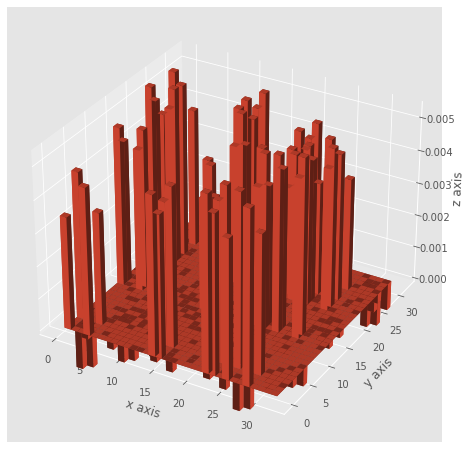

<IPython.core.display.Latex object>

[ 0  1  2 ... 29 30 31] [ 0  0  0 ... 31 31 31]


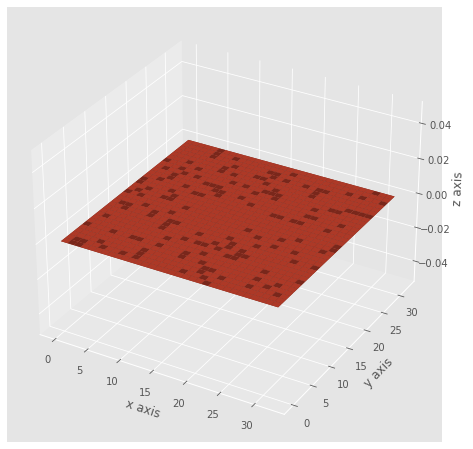

<IPython.core.display.Latex object>

[ 0  1  2 ... 29 30 31] [ 0  0  0 ... 31 31 31]


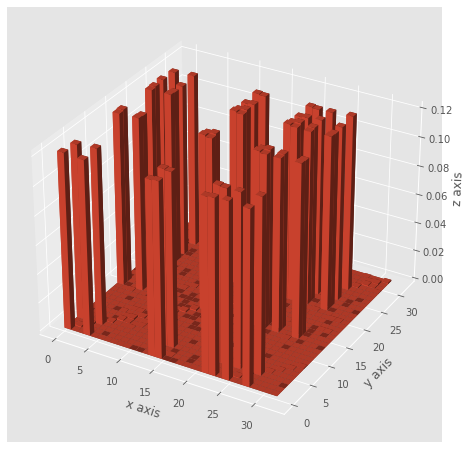

<IPython.core.display.Latex object>

[ 0  1  2 ... 29 30 31] [ 0  0  0 ... 31 31 31]


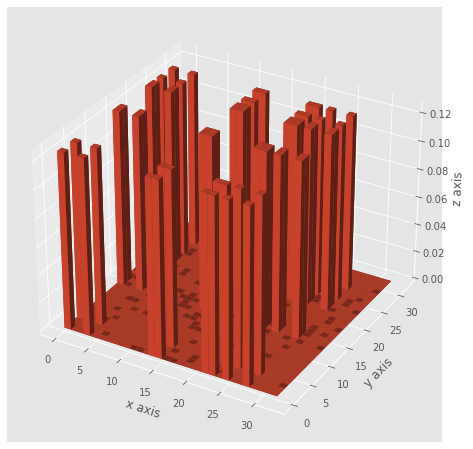

In [536]:
# сравним распределения до стадии измерений
display(Latex(r'$ |\rho^{end}| - |\rho^{end}_{noisy}|$ '))
plot_matrix(np.abs(rho_new) - np.abs(rho_new_noise))
display(Latex(r'$ |\rho^{end}| - |\rho^{res}|$ '))
plot_matrix(np.abs(rho_new) - np.abs(res_rho))
display(Latex(r' $|\rho^{end}_{noisy}|$ '))
plot_matrix(np.abs(rho_new_noise))
display(Latex(r' $|\rho^{res}|$ '))
plot_matrix(np.abs(res_rho))

In [537]:
res

,state,IBM,IBMsim,Simulation
0,00000,0.0550,0.125,0.101607
1,00001,0.0121,0.000,0.005134
2,00010,0.0138,0.000,0.006264
3,00011,0.0445,0.125,0.096291
4,00100,0.0470,0.000,0.016218
5,00101,0.0098,0.000,0.007225
6,00110,0.0129,0.000,0.007474
7,00111,0.0405,0.000,0.015050
8,01000,0.0114,0.000,0.007244
9,01001,0.0110,0.000,0.012824
